In [1]:
import time

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
from skimage import img_as_float
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

%matplotlib inline

import os

from utils import *
from models import *
from train import *
from test import *

### Load Data:

In [2]:
clocks = read_folder('clock/')
clocks_l = np.zeros(clocks.shape[0]) #assign labels

crocs = read_folder('crocodile/')
crocs_l = np.ones(crocs.shape[0]) #assign labels

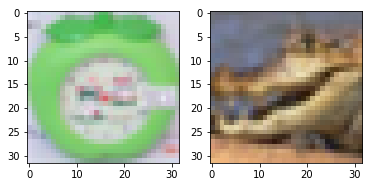

In [3]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.transpose(clocks[0], (1,2,0)))
ax[1].imshow(np.transpose(crocs[0], (1,2,0)));

### Split & Augment:

In [4]:
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(np.concatenate([clocks.copy(), crocs.copy()], axis=0),
                                                                      np.concatenate([clocks_l.copy(), crocs_l.copy()], axis=0))

Train size: (700, 3, 32, 32)
Test size: (240, 3, 32, 32)
Validation size: (60, 3, 32, 32)


In [5]:
X_train_aug, y_train_aug = augment_dataset(X_train, y_train, n=1)
print('Test size:',X_test.shape, ' with ratio ', X_test.shape[0]/X_train.shape[0])
print('Validation size:',X_val.shape)

100%|██████████| 700/700 [00:00<00:00, 2096.57it/s]

Augmented Train size: (2100, 3, 32, 32)
Test size: (240, 3, 32, 32)  with ratio  0.34285714285714286
Validation size: (60, 3, 32, 32)


You can see how augmentation does work:

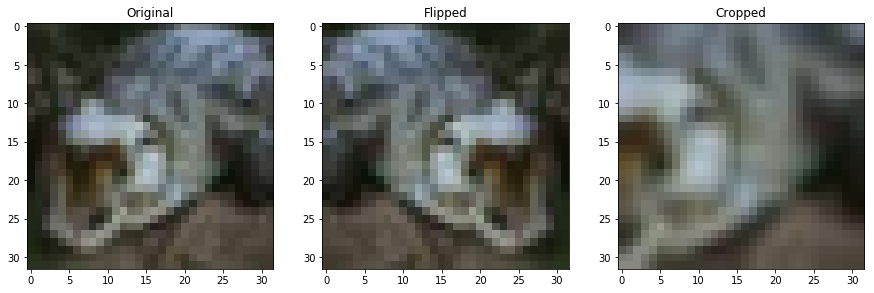

In [6]:
img1 = crocs[6].copy()
rot1 = augment_rotation(img1.reshape(1,3,32,32))[0,...]
cr1 = augment_crop(img1, size=20)

fig, ax = plt.subplots(1,3, figsize=(15,7))
ax[0].imshow(np.transpose(img1, (1,2,0)))
ax[0].set_title('Original')
ax[1].imshow(np.transpose(rot1, (1,2,0)))
ax[1].set_title('Flipped')
ax[2].imshow(np.transpose(cr1, (1,2,0)))
ax[2].set_title('Cropped');

P.S. I know that I can incorporate augmentation directly into training proccess with PyTorch, but I prefer to do it in old-school way - it allows more controll and the dataset is tiny, so it's cheap.

### Task 1. Classify:

I bet we can solve this task with very simple NN, however for task 2 we will need more or less considerable CNN to compute convolutional feature because I want to use the perceptual loss as the measure of closeness of images. So, I will firstly just demonstrate the work of simple NN and the train more complex CNN.

 - #### Shallow NN:

In [7]:
shallow_model = ShallowNN().cuda()
opt = torch.optim.Adam(shallow_model.parameters())

In [8]:
shallow_model = train_network(model=shallow_model, opt=opt, batch_size=128, num_epochs=16,
                              train_data=(X_train_aug, y_train_aug))

A Jupyter Widget

In [9]:
test_model(shallow_model, test_data=(X_test,y_test), Flatten=True)

Results:
  test accuracy:		63.00 %


Satisfactory for the simplest model.

 - #### CNN:

In [10]:
model = SimpleCNN().cuda()
opt = torch.optim.Adam(model.parameters())

In [11]:
model = train_network(model, opt, train_data=(X_train_aug, y_train_aug),
                      validation_data=(X_val, y_val))

A Jupyter Widget

Epoch 1 of 11 took 3.387s
  training loss (in-iteration): 	0.544667
  validation accuracy: 			75.00 %
Epoch 2 of 11 took 3.141s
  training loss (in-iteration): 	0.412108
  validation accuracy: 			71.67 %
Epoch 3 of 11 took 3.079s
  training loss (in-iteration): 	0.386856
  validation accuracy: 			76.67 %
Epoch 4 of 11 took 3.115s
  training loss (in-iteration): 	0.328318
  validation accuracy: 			90.00 %
Epoch 5 of 11 took 3.388s
  training loss (in-iteration): 	0.301317
  validation accuracy: 			86.67 %
Epoch 6 of 11 took 3.190s
  training loss (in-iteration): 	0.280878
  validation accuracy: 			83.33 %
Epoch 7 of 11 took 3.088s
  training loss (in-iteration): 	0.220438
  validation accuracy: 			90.00 %
Epoch 8 of 11 took 3.131s
  training loss (in-iteration): 	0.193049
  validation accuracy: 			88.33 %
Epoch 9 of 11 took 3.233s
  training loss (in-iteration): 	0.184256
  validation accuracy: 			93.33 %
Epoch 10 of 11 took 3.074s
  training loss (in-iteration): 	0.175609
  validation 

Good, let's a bit fine-tune our model on the part of training data we used for validation:

In [12]:
opt.param_groups[0]['lr'] = opt.param_groups[0]['lr']/100
model = fine_tune(model,opt,train_data=(X_val, y_val))

100%|██████████| 3/3 [00:00<00:00, 14.47it/s]


In [13]:
test_model(model, test_data=(X_test,y_test))

Results:
  test accuracy:		92.50 %


We achieved considerable accuracy! We could still earn it with fewer layers, but we need more or less deep network to produce features that are abstract enough. For example, with no 4-th conv. layer accuracy is still the same, but it's hard to use such network in the second task.

### Task 2. Finding images that look like both clock and crocodile.

For this task I purpose to use so-called perceptual loss. We will take features that some layer of our network produces and define it as the measure of similiarity between images.

Next, if we imagine two clusters of clocks and crocodiles, then we can estimate the centers of these clusters as just the mean of all images (their convolutional features). Then, we can take embeddings of all our images and substitute centers of the cluster. It actually won't tell us what images are both like clock and crocodile, but it will help to rank them in a way like what clocks look more like a crocodile and what crocodiles look more like a clock. Then, in this ranked array of images, we can take images located near the center of and it will return us images that lay clothes to both clusters.

Empiricaly, I found that taking features of the last fully-connected layer (so-called fc7 features), rank images as described above and take them from one of the edges earns best results.

In [14]:
simillar_images=get_perceptual_neighbors(trained_model=model, first_cluster=crocs, second_cluster=clocks, N=15)

Estimating convolutional features...
Estimating convolutional features...
Estimating convolutional features...


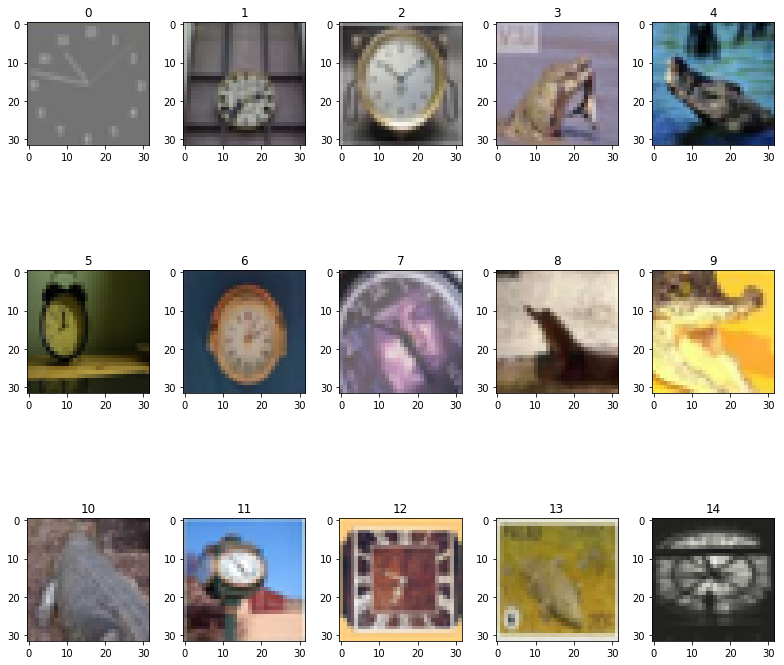

In [15]:
fig, ax = plt.subplots(3,5, figsize=(11,11))
c = 0
for i in range(3):
    for j in range(5):
        ax[i,j].imshow(np.transpose(simillar_images[c],(1,2,0)))
        ax[i,j].set_title(str(c))
        c+=1
plt.tight_layout();

As we see, several images that this approach finds, are really close to both clock and crocodiles.

One may see that it relies on textures and colors. For example, NN may select images $6,11$ here, because a blue background is much more common for crocodiles because of the water behind. An image with index $8$ may have been selected because the same reason it's too contrast for crocodile and such contrast is common for clocks on the white wall. 

Based on this and on other selected images, one can conclude that this method relies on textures and colors, it's not perfect, but if we can produce more abstract convolutional features with deeper network, I believe it will work good.

P.S. I also tried an approach with convolutional autoencoder. And again, I was striving to create deep embeddings for images. However, it seems that such autoencoder should be very deep to produce more or less usefull deep features.

### Task 3. Generate half clock, half crocodile

In progress. I try to use conditional dcGAN and VAE. 

dcGAN seems to fail because either I train it in no so appropriate way or such tiny dataset is not enough for dcGAN to converge. An idea is to condition generator and discriminator with class labels og $(0,1)$ and then, when we want to obtain a mix of clock and crocodile, interpolate and condition generator as $(0.5, 0.5)$

I haven't tried VAE yet, but it might actually work. To be continued...